## Notebook for interpreting ML through SHAP

#### Model: LightGBM

#### Splitting: Stratified-II

**Created on 21st September, 2022; remodified on 12th February, 2024**

In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
import numpy as np
#import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, LassoCV, \
    RidgeClassifier, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, SVC
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel, \
RationalQuadratic, ExpSineSquared, DotProduct
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, \
precision_score, auc
import sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import pickle
#import optuna
import lightgbm as lgb
from lightgbm import LGBMRegressor
import shap

In [2]:
%%bash
pwd
ls -ltr

/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/Science-rev-1/coulombic-efficiency_1.1/using-pretrainedGR/gr-embed-200/common-log-output/stratified-split-2-cv
total 9456
-rw-r--r--    1 riteshk  staff  907086 Jan 17 14:41 train_gr_comb_add.csv
-rw-r--r--    1 riteshk  staff  126776 Jan 17 14:41 test_gr_comb_add.csv
-rw-r--r--    1 riteshk  staff  118767 Jan 17 14:41 val_gr_comb_add.csv
-rw-r--r--    1 riteshk  staff  261305 Jan 17 14:49 ood_gr_comb_add.csv
-rw-r--r--    1 riteshk  staff  126776 Jan 17 15:36 strat_rs0_test_gr_comb_add.csv
-rw-r--r--@   1 riteshk  staff  907575 Jan 17 15:36 strat_rs0_train_gr_comb_add.csv
-rw-r--r--    1 riteshk  staff  118592 Jan 17 15:36 strat_rs0_val_gr_comb_add.csv
-rw-r--r--    1 riteshk  staff  126589 Jan 17 15:36 strat_rs17_test_gr_comb_add.csv
-rw-r--r--    1 riteshk  staff  907607 Jan 17 15:36 strat_rs17_train_gr_comb_add.csv
-rw-r--r--    1 riteshk  staff  118747 Jan 17 15:36 strat_rs17_val_gr_comb_add.csv
-rw

In [4]:
train_df = pd.read_csv('strat_rs30_train_gr_comb_add.csv')
val_df = pd.read_csv('strat_rs30_val_gr_comb_add.csv')
test_df = pd.read_csv('strat_rs30_test_gr_comb_add.csv')
train_df

,solv_smile_comb,salt_smile_comb,solv_fp_0_mol_0,solv_fp_1_mol_0,solv_fp_2_mol_0,solv_fp_3_mol_0,solv_fp_4_mol_0,solv_fp_5_mol_0,solv_fp_6_mol_0,solv_fp_7_mol_0,...,solv_ratio_3,mw_salt_1,mw_salt_2,salt_1_conc,salt_2_conc,mw_add,protocol,current_density,log(1-CE),CE_binned
0,C1COCO1.COCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+].O=S(=O)([N-]S(=...,-0.006039,-0.004283,-0.013746,-0.005626,-0.005084,-0.004713,-0.006876,0.033564,...,0.0,186.939685,286.933298,0.50,0.5,0.000000,3,0.25,-2.000000,2
1,COCCOCCOCCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+].O=C1OCCO1,-0.005236,0.010172,-0.012011,-0.008903,-0.006002,-0.005831,-0.007050,0.042227,...,0.0,186.939685,0.000000,3.00,0.0,88.016044,1,0.40,-1.443697,3
2,O=C1OCCO1.CCOC(=O)OCC,[Li+].[O-][Cl+3]([O-])([O-])[O-],0.069424,0.046331,-0.015139,0.083333,-0.011125,-0.007302,-0.011989,-0.007036,...,0.0,105.964516,0.000000,1.00,0.0,0.000000,1,1.00,-0.856985,5
3,O=C1OCC(F)O1.COCCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],0.137776,0.012570,-0.012399,0.089359,-0.008272,-0.005663,0.001472,0.037405,...,0.0,186.939685,0.000000,1.00,0.0,0.000000,4,1.00,-0.918653,4
4,CCCCOCCCC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.006658,0.133333,-0.013576,-0.009701,0.071500,-0.006591,-0.007900,0.008567,...,0.0,186.939685,0.000000,2.00,0.0,0.000000,4,0.50,-2.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,COCCCCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.005567,0.036068,-0.012261,-0.009823,-0.004649,-0.006229,-0.007929,-0.004282,...,0.0,186.939685,0.000000,1.00,0.0,0.000000,2,0.50,-1.638272,3
108,O=C1OCCO1.CCOC(=O)OCC,F[P-](F)(F)(F)(F)F.[Li+].O=C1OCC(F)O1,0.069424,0.046331,-0.015139,0.083333,-0.011125,-0.007302,-0.011989,-0.007036,...,0.0,151.980186,0.000000,1.00,0.0,106.006622,3,0.50,-1.301030,4
109,CCOCC.C1CCOC1,F[As-](F)(F)(F)(F)F.[Li+],-0.007749,0.035542,-0.014806,-0.008115,-0.005807,-0.005667,-0.008082,0.008053,...,0.0,195.928020,0.000000,2.50,0.0,0.000000,2,5.00,-1.657577,3
110,COC(=O)OCC(F)(F)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],0.122961,-0.008040,-0.009732,-0.003611,-0.012537,-0.005110,-0.008643,-0.008926,...,0.0,186.939685,0.000000,3.16,0.0,0.000000,2,0.50,-1.275724,4


In [5]:
X_train = train_df.iloc[:,2:-2]
y_train = train_df.iloc[:,-2]

X_test = test_df.iloc[:,2:-2]
y_test = test_df.iloc[:,-2]

X_val = val_df.iloc[:,2:-2]
y_val = val_df.iloc[:,-2]

## scaling the data
scaler = MinMaxScaler().fit(X_train.iloc[:,-13:])
X_train_scaled = scaler.transform(X_train.iloc[:,-13:])
X_train_ = np.concatenate((X_train.iloc[:,:-13], X_train_scaled), axis=1)
X_val_scaled = scaler.transform(X_val.iloc[:,-13:])
X_val_ = np.concatenate((X_val.iloc[:,:-13], X_val_scaled), axis=1)
X_test_scaled = scaler.transform(X_test.iloc[:,-13:])
X_test_ = np.concatenate((X_test.iloc[:,:-13], X_test_scaled), axis=1)

In [6]:
pred_array = []

plsr_models = []
for i in range(1,6):
    filename = f'./plsr_model_strat_ncomp_11_fold_{i}.sav'
    loaded_model = pickle.load(open(filename, 'rb'))
    plsr_models.append(loaded_model)
    y_pred_test = loaded_model.predict(X_test_)
    pred_array.append(y_pred_test)

y_l = x_l = np.linspace(-6, -0.5, 100)
y_pred_ood_avg = np.mean(pred_array, axis=0)
y_pred_ood_avg = np.ravel(y_pred_ood_avg)
y_pred_ood_std = np.std(pred_array, axis=0)
y_pred_ood_std = np.ravel(y_pred_ood_std)
rmse_ood = np.sqrt(mean_squared_error(y_test, y_pred_ood_avg)); mae_ood = mean_absolute_error(y_test, y_pred_ood_avg); r2_ood = r2_score(y_test, y_pred_ood_avg)
print(f"Avg RMSE test: {rmse_ood}, Avg MAE test: {mae_ood}, Avg R2 test: {r2_ood}")

Avg RMSE test: 0.4110886311472843, Avg MAE test: 0.30336821458722707, Avg R2 test: 0.5568982376847902


In [6]:
# model = plsr_models[0] ## choosing 1st model to get the shap values

In [7]:
# df_all = pd.read_csv('all_qsar_cond.csv')
df_all = pd.concat([train_df, val_df, test_df], axis=0)
df_all.reset_index(drop=True, inplace=True)
df_all

,solv_smile_comb,salt_smile_comb,solv_fp_0_mol_0,solv_fp_1_mol_0,solv_fp_2_mol_0,solv_fp_3_mol_0,solv_fp_4_mol_0,solv_fp_5_mol_0,solv_fp_6_mol_0,solv_fp_7_mol_0,...,solv_ratio_3,mw_salt_1,mw_salt_2,salt_1_conc,salt_2_conc,mw_add,protocol,current_density,log(1-CE),CE_binned
0,C1COCO1.COCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+].O=S(=O)([N-]S(=...,-0.006039,-0.004283,-0.013746,-0.005626,-0.005084,-0.004713,-0.006876,0.033564,...,0.0,186.939685,286.933298,0.5,0.5,0.000000,3,0.25,-2.000000,2
1,COCCOCCOCCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+].O=C1OCCO1,-0.005236,0.010172,-0.012011,-0.008903,-0.006002,-0.005831,-0.007050,0.042227,...,0.0,186.939685,0.000000,3.0,0.0,88.016044,1,0.40,-1.443697,3
2,O=C1OCCO1.CCOC(=O)OCC,[Li+].[O-][Cl+3]([O-])([O-])[O-],0.069424,0.046331,-0.015139,0.083333,-0.011125,-0.007302,-0.011989,-0.007036,...,0.0,105.964516,0.000000,1.0,0.0,0.000000,1,1.00,-0.856985,5
3,O=C1OCC(F)O1.COCCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],0.137776,0.012570,-0.012399,0.089359,-0.008272,-0.005663,0.001472,0.037405,...,0.0,186.939685,0.000000,1.0,0.0,0.000000,4,1.00,-0.918653,4
4,CCCCOCCCC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.006658,0.133333,-0.013576,-0.009701,0.071500,-0.006591,-0.007900,0.008567,...,0.0,186.939685,0.000000,2.0,0.0,0.000000,4,0.50,-2.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,C1COCO1.COCCOC,O=S(=O)([N-]S(=O)(=O)C(F)(F)F)C(F)(F)F.[Li+].O...,-0.005876,-0.003536,-0.013445,-0.006262,-0.005175,-0.005150,-0.007151,0.047249,...,0.0,286.933298,0.000000,1.0,0.0,69.003822,0,0.50,-2.000000,2
138,O=C1OCCO1.COC(=O)OC,F[P-](F)(F)(F)(F)F.[Li+].O=C1OCC(F)O1,0.070854,0.054446,-0.014466,0.087637,-0.011126,-0.007172,-0.011968,-0.006509,...,0.0,151.980186,0.000000,1.0,0.0,106.006622,2,1.00,-1.318759,3
139,O=C1OCCO1.CCOC(=O)OC,F[P-](F)(F)(F)(F)F.[Li+],0.064821,0.049995,-0.014755,0.082037,-0.011125,-0.007197,-0.012041,-0.006816,...,0.0,151.980186,0.000000,1.0,0.0,0.000000,1,0.50,-0.742321,5
140,COCCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.005390,-0.004935,-0.011686,-0.010327,-0.004394,-0.005828,-0.007275,0.091065,...,0.0,186.939685,0.000000,4.0,0.0,0.000000,1,0.20,-2.045757,2


In [8]:
X_all = df_all.iloc[:,2:-2]
X_all_scaled = scaler.transform(X_all.iloc[:,-13:])
X_all_ = np.concatenate((X_all.iloc[:,:-13], X_all_scaled), axis=1)
X_all_ = pd.DataFrame(X_all_, columns=X_all.columns)
X_all_

,solv_fp_0_mol_0,solv_fp_1_mol_0,solv_fp_2_mol_0,solv_fp_3_mol_0,solv_fp_4_mol_0,solv_fp_5_mol_0,solv_fp_6_mol_0,solv_fp_7_mol_0,solv_fp_8_mol_0,solv_fp_9_mol_0,...,solv_ratio_1,solv_ratio_2,solv_ratio_3,mw_salt_1,mw_salt_2,salt_1_conc,salt_2_conc,mw_add,protocol,current_density
0,-0.006039,-0.004283,-0.013746,-0.005626,-0.005084,-0.004713,-0.006876,0.033564,-0.008454,-0.006280,...,0.666333,0.333667,0.0,0.288206,1.0,0.020619,0.217391,0.000000,0.8,0.030612
1,-0.005236,0.010172,-0.012011,-0.008903,-0.006002,-0.005831,-0.007050,0.042227,-0.010130,-0.007376,...,1.000000,0.000000,0.0,0.288206,0.0,0.278351,0.000000,0.316753,0.4,0.061224
2,0.069424,0.046331,-0.015139,0.083333,-0.011125,-0.007302,-0.011989,-0.007036,-0.010284,-0.013385,...,0.269541,0.730459,0.0,0.000000,0.0,0.072165,0.000000,0.000000,0.4,0.183673
3,0.137776,0.012570,-0.012399,0.089359,-0.008272,-0.005663,0.001472,0.037405,-0.009678,-0.010197,...,0.499500,0.500500,0.0,0.288206,0.0,0.072165,0.000000,0.000000,1.0,0.183673
4,-0.006658,0.133333,-0.013576,-0.009701,0.071500,-0.006591,-0.007900,0.008567,-0.011650,-0.004249,...,1.000000,0.000000,0.0,0.288206,0.0,0.175258,0.000000,0.000000,1.0,0.081633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,-0.005876,-0.003536,-0.013445,-0.006262,-0.005175,-0.005150,-0.007151,0.047249,-0.008882,-0.006407,...,0.499500,0.500500,0.0,0.644103,0.0,0.072165,0.000000,0.248332,0.2,0.081633
138,0.070854,0.054446,-0.014466,0.087637,-0.011126,-0.007172,-0.011968,-0.006509,-0.010096,-0.013087,...,0.332667,0.667333,0.0,0.163779,0.0,0.072165,0.000000,0.381498,0.6,0.183673
139,0.064821,0.049995,-0.014755,0.082037,-0.011125,-0.007197,-0.012041,-0.006816,-0.010138,-0.013183,...,0.499500,0.500500,0.0,0.163779,0.0,0.072165,0.000000,0.000000,0.4,0.081633
140,-0.005390,-0.004935,-0.011686,-0.010327,-0.004394,-0.005828,-0.007275,0.091065,-0.010062,-0.007175,...,1.000000,0.000000,0.0,0.288206,0.0,0.381443,0.000000,0.000000,0.4,0.020408


In [9]:
# # explainerModel = shap.TreeExplainer(model = model)
# masker = shap.maskers.Independent(X_all_)
# # explainerModel = shap.LinearExplainer(model = model, data = X_all)
# explainerModel = shap.LinearExplainer(model = model, masker = masker)
# shap_values = explainerModel.shap_values(X_all_)

In [ ]:
# ## save the SHAP values
# cols_X = X_all.columns
# cols_shap = [('shap_' + cols_X[i]) for i in range(len(cols_X))]
# shap_df = pd.DataFrame(shap_values)
# shap_df.columns = cols_shap
# # shap_df.to_csv('shap_values_all.csv', index=False)
# shap_df

In [ ]:
# comb_df = pd.concat([X_all,shap_df], axis=1)
# comb_df['log(1-CE)'] = df_all['log(1-CE)']
# comb_df

In [15]:
shap_values_all = []
for i in range(5):
    model = plsr_models[i] ## models trained on each fold
    masker = shap.maskers.Independent(X_all_)
    explainerModel = shap.LinearExplainer(model = model, masker=masker) ## using LinearExplainer for PLSR
    shap_values = explainerModel.shap_values(X_all_)
    shap_values_all.append(shap_values)

shap_values_all = np.array(shap_values_all)
shap_values_all_mean = np.mean(shap_values_all, axis=0) ## average SHAP values across all models
cols_X = X_all.columns
cols_shap = [('shap_' + cols_X[i]) for i in range(len(cols_X))]
shap_df = pd.DataFrame(shap_values_all_mean)
shap_df.columns = cols_shap
# shap_df.to_csv('shap_values_all.csv', index=False)

comb_df = pd.concat([X_all,shap_df], axis=1)
comb_df['log(1-CE)'] = df_all['log(1-CE)']
comb_df

,solv_fp_0_mol_0,solv_fp_1_mol_0,solv_fp_2_mol_0,solv_fp_3_mol_0,solv_fp_4_mol_0,solv_fp_5_mol_0,solv_fp_6_mol_0,solv_fp_7_mol_0,solv_fp_8_mol_0,solv_fp_9_mol_0,...,shap_solv_ratio_2,shap_solv_ratio_3,shap_mw_salt_1,shap_mw_salt_2,shap_salt_1_conc,shap_salt_2_conc,shap_mw_add,shap_protocol,shap_current_density,log(1-CE)
0,-0.006039,-0.004283,-0.013746,-0.005626,-0.005084,-0.004713,-0.006876,0.033564,-0.008454,-0.006280,...,-0.009562,-0.00183,0.025292,-0.462210,0.165907,0.146129,0.029908,0.078804,-0.045701,-2.000000
1,-0.005236,0.010172,-0.012011,-0.008903,-0.006002,-0.005831,-0.007050,0.042227,-0.010130,-0.007376,...,0.087831,-0.00183,0.025292,0.036717,-0.171907,-0.025384,-0.084349,-0.019089,-0.035179,-1.443697
2,0.069424,0.046331,-0.015139,0.083333,-0.011125,-0.007302,-0.011989,-0.007036,-0.010284,-0.013385,...,-0.125381,-0.00183,-0.194045,0.036717,0.098345,-0.025384,0.029908,-0.019089,0.006910,-0.856985
3,0.137776,0.012570,-0.012399,0.089359,-0.008272,-0.005663,0.001472,0.037405,-0.009678,-0.010197,...,-0.058259,-0.00183,0.025292,0.036717,0.098345,-0.025384,0.029908,0.127751,0.006910,-0.918653
4,-0.006658,0.133333,-0.013576,-0.009701,0.071500,-0.006591,-0.007900,0.008567,-0.011650,-0.004249,...,0.087831,-0.00183,0.025292,0.036717,-0.036781,-0.025384,0.029908,0.127751,-0.028164,-2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,-0.005876,-0.003536,-0.013445,-0.006262,-0.005175,-0.005150,-0.007151,0.047249,-0.008882,-0.006407,...,-0.058259,-0.00183,0.296145,0.036717,0.098345,-0.025384,-0.059669,-0.068036,-0.028164,-2.000000
138,0.070854,0.054446,-0.014466,0.087637,-0.011126,-0.007172,-0.011968,-0.006509,-0.010096,-0.013087,...,-0.106955,-0.00183,-0.069403,0.036717,0.098345,-0.025384,-0.107703,0.029858,0.006910,-1.318759
139,0.064821,0.049995,-0.014755,0.082037,-0.011125,-0.007197,-0.012041,-0.006816,-0.010138,-0.013183,...,-0.058259,-0.00183,-0.069403,0.036717,0.098345,-0.025384,0.029908,-0.019089,-0.028164,-0.742321
140,-0.005390,-0.004935,-0.011686,-0.010327,-0.004394,-0.005828,-0.007275,0.091065,-0.010062,-0.007175,...,0.087831,-0.00183,0.025292,0.036717,-0.307033,-0.025384,0.029908,-0.019089,-0.049209,-2.045757


**SHAP summary plot**

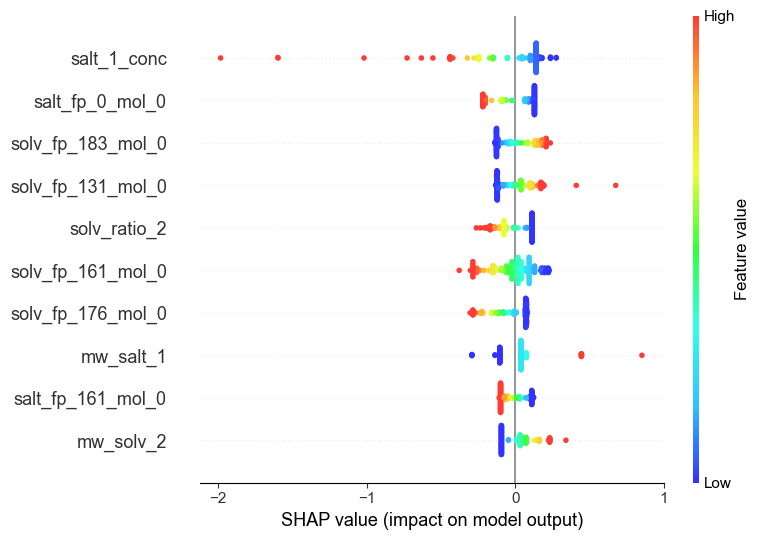

In [18]:
## Color scheme according to origin plots
c1 = '#3333FF'; c1 = mcolors.to_rgb(c1)
c2 = '#33C2FF'; c2 = mcolors.to_rgb(c2)
c3 = '#33FFE8'; c3 = mcolors.to_rgb(c3)
c4 = '#33FF3B'; c4 = mcolors.to_rgb(c4)
c5 = '#E9FF33'; c5 = mcolors.to_rgb(c5)
c6 = '#FFC133'; c6 = mcolors.to_rgb(c6)
c7 = '#FF3B33'; c7 = mcolors.to_rgb(c7)
# cmap1_or = mcolors.LinearSegmentedColormap.from_list("", [c7,c6,c5,c4,c3,c2,c1]) ## from red to blue
cmap1 = mcolors.LinearSegmentedColormap.from_list("", [c1,c2,c3,c4,c5,c6,c7]) ## from blue to red
shap.summary_plot(shap_values, X_all_, max_display=10, show=False, cmap=cmap1)
ax = plt.gca()
ax.set_xticks([-2,-1,0,1])
plt.savefig('shap_plsr_stratII_summary_ce.eps', dpi=300)

**SHAP dependence plots**

In [34]:
# comb_df = comb_df.sort_values(by=['salt_fp_194_mol_0'], ascending=False)

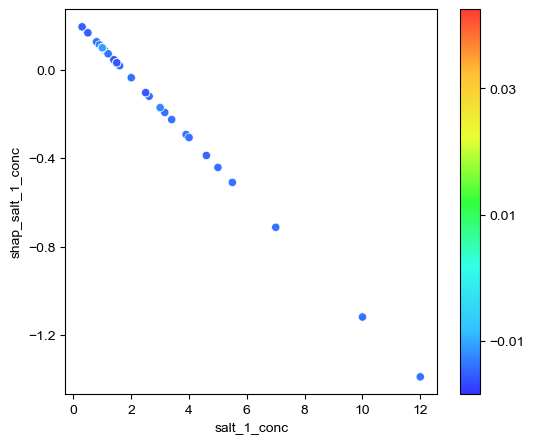

In [21]:
## For salt conc-1
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.scatterplot(x='salt_1_conc', y='shap_salt_1_conc', data=comb_df, hue='salt_fp_194_mol_0', palette=cmap1)
norm = plt.Normalize(df_all['salt_fp_194_mol_0'].min(), df_all['salt_fp_194_mol_0'].max())
# norm = plt.Normalize(comb_df['salt_fp_194_mol_0'].min(), comb_df['salt_fp_194_mol_0'].max())
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.set_yticks([-1.2, -0.8, -0.4, 0.0])
ax.figure.colorbar(sm, ticks=[-0.01, 0.01, 0.03])
plt.savefig('shap_plsr_stratII_salt_1_conc_dependence_ce.eps', dpi=300)

In [51]:
# comb_df = comb_df.sort_values(by=['temperature'], ascending=True)

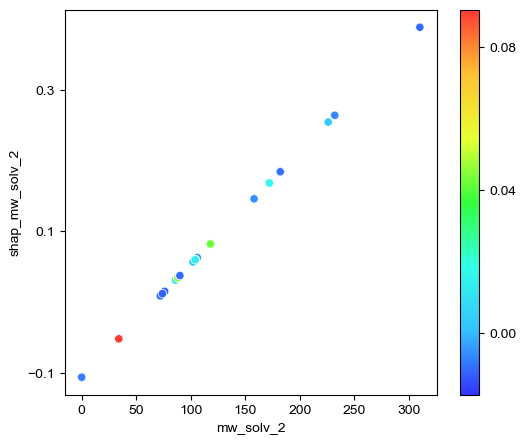

In [23]:
## For MW solv-2
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.scatterplot(x='mw_solv_2', y='shap_mw_solv_2', data=comb_df, hue='solv_fp_56_mol_0', palette=cmap1)
norm = plt.Normalize(df_all['solv_fp_56_mol_0'].min(), df_all['solv_fp_56_mol_0'].max())
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.set_yticks([-0.1, 0.1, 0.3])
ax.figure.colorbar(sm, ticks=[0.00, 0.04, 0.08])
# ax.figure.colorbar(sm)
plt.savefig('shap_plsr_stratII_mw_solv_2_dependence_ce.eps', dpi=300)